# Analysis of full demolition permits by the City of Austin

- This analysis starts with a file that has been downloaded and processed in another notebook, `01_Download_Process.ipynb`.

## Set up and configurations

In [1]:
import pandas as pd
import altair as alt
pd.options.display.max_colwidth = 60

## Import file

In [2]:
# Column type fixes
column_types = {
    'ApplicantPhone': pd.np.str,
    'ContractorPhone': pd.np.str,
    'CalendarYearIssued': pd.np.str,
    'OriginalZip': pd.np.str,
#     'IssuedDate': pd.np.str,
}

# import raw data
data_raw = pd.read_csv(
    '../data-processed/demolitions_full.csv',
    index_col=None,
    dtype=column_types,
    parse_dates=['IssuedDate']
)

demolitions = data_raw

demolitions.shape

(3165, 68)

## Total cases

In [3]:
print('Number of full demolitions from Jan. 2008 to July 2018 be additions:\n\n{}'.format(len(demolitions)))


Number of full demolitions from Jan. 2008 to July 2018 be additions:

3165


## How the number of demolition permits have changed over time

How many demolition permits have been been issued in past years.

### Permits per year

In [4]:
# create data from of permits by year
demos_by_year = demolitions.CalendarYearIssued.value_counts().reset_index()
demos_by_year.columns = ['Year', 'Count']
demos_by_year.sort_values('Year')

,Year,Count
10,2008,110
9,2009,137
8,2010,152
7,2011,176
6,2012,263
4,2013,328
2,2014,357
3,2015,345
1,2016,450
0,2017,566


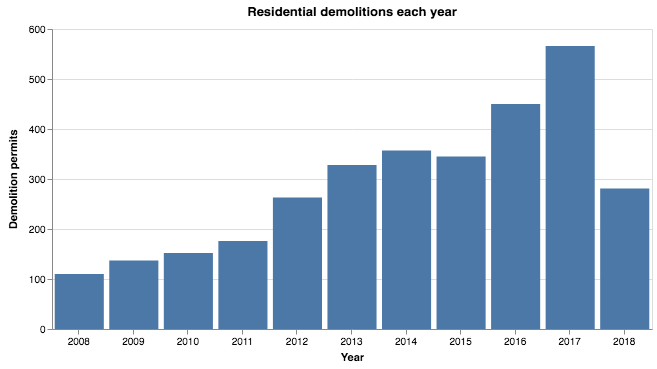

In [5]:
# make chart
alt.Chart(demos_by_year.reset_index(), title="Residential demolitions each year").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

### Permits in first half of year

If we want to see how permits are going for 2018, we need to look at the first six months of each year and compare them.

In [6]:
# Filter demolitions to only those before July in any given year
six_months_filtered = demolitions[demolitions.IssuedDate.dt.month < 7]
six_months_filtered.shape

(1659, 68)

In [7]:
six_months_data = six_months_filtered.CalendarYearIssued.value_counts().reset_index()
six_months_data.columns = ['Year', 'Count']
six_months_data

,Year,Count
0,2017,306
1,2018,281
2,2014,176
3,2013,167
4,2016,159
5,2015,150
6,2012,132
7,2011,84
8,2010,75
9,2009,68


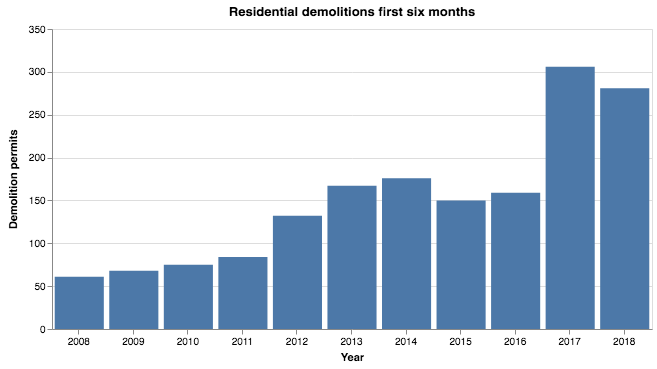

In [8]:
# make chart
alt.Chart(six_months_data.reset_index(), title="Residential demolitions first six months").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

## Square footage of residential homes demolished

In [9]:
demos_spft = demolitions.groupby('CalendarYearIssued').sum().TotalExistingBldgSQFT.reset_index()
demos_spft.columns = ['Year', 'SqFt']
demos_spft

,Year,SqFt
0,2008,131987.0
1,2009,172399.0
2,2010,197725.0
3,2011,245702.0
4,2012,339043.0
5,2013,294329.0
6,2014,425708.0
7,2015,360855.0
8,2016,665513.0
9,2017,846699.0


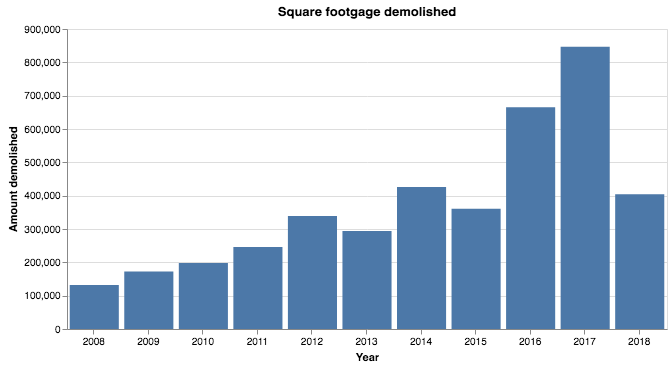

In [10]:
alt.Chart(demos_spft.reset_index(), title="Square footgage demolished").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("SqFt:Q", axis=alt.Axis(title="Amount demolished")),
).properties(width=600)

### Pace by square footage first half of year
It looks like the pace for 2018, is a bit less than 2017.

In [11]:
# group by year, sqft totals for first six months
demos_spft_6mo = six_months_filtered.groupby(
    'CalendarYearIssued'
).sum().TotalExistingBldgSQFT.reset_index()
demos_spft_6mo.columns = ['Year', 'SqFt']
demos_spft_6mo

,Year,SqFt
0,2008,78621.0
1,2009,74045.0
2,2010,95895.0
3,2011,126032.0
4,2012,180176.0
5,2013,87939.0
6,2014,207848.0
7,2015,159388.0
8,2016,201239.0
9,2017,505389.0


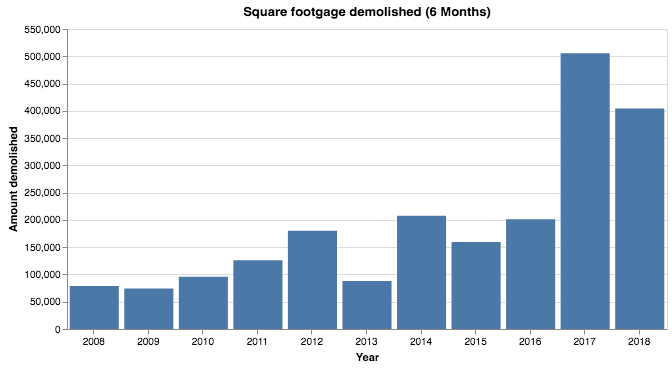

In [12]:
alt.Chart(demos_spft_6mo.reset_index(), title="Square footgage demolished (6 Months)").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("SqFt:Q", axis=alt.Axis(title="Amount demolished")),
).properties(width=600)

## Demolitions by Zip code

In [13]:
# make a datafram with counts of permits by zip code
demos_by_zip = demolitions.OriginalZip.value_counts().reset_index()
demos_by_zip.columns = ['Zip', 'Count']
demos_by_zip.head()

,Zip,Count
0,78704,624
1,78702,552
2,78703,371
3,78757,215
4,78731,174


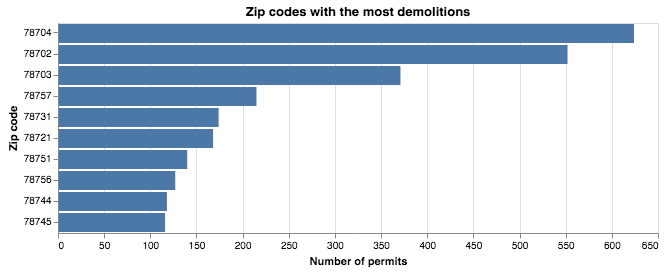

In [14]:
alt.Chart(demos_by_zip.head(10), title="Zip codes with the most demolitions").mark_bar().encode(
    x=alt.X("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    y=alt.Y("Zip:O",
            # this is the sorting magic
            sort=alt.SortField(field="Count", order="descending", op="sum"),
            axis=alt.Axis(title="Zip code")),
).properties(width=600)

## Demolitions by zip code and year

Which parts of town are getting worse?

In [15]:
# this is all years, then grouped by year, zip and count
demos_yr_zip_all = demolitions.groupby(['CalendarYearIssued','OriginalZip']).agg(dict(
    PermitNum='count'
)).reset_index()
demos_yr_zip_all.columns = ['Year', 'Zip', 'Count']
demos_yr_zip_all.shape

(284, 3)

In [16]:
# Filter out 2018 because it is a partial year
before_2018 = demolitions[demolitions['CalendarYearIssued'] != '2018']

# build a dataframe of yr, zip, count
demos_yr_zip = before_2018.groupby(['CalendarYearIssued','OriginalZip']).agg(dict(
    PermitNum='count'
)).reset_index()
demos_yr_zip.columns = ['Year', 'Zip', 'Count']
demos_yr_zip.shape
# demos_yr_zip.head()

(260, 3)

#### Top Zips over time

This method takes the top 10 Zips from the chart above and uses those to map out.

In [17]:
# filter to top zips
top_zips = ['78704', '78702', '78703', '78757', '78731',
            '78721', '78751', '78756', '78744', '78745']

top_demos_yr_zip = demos_yr_zip[demos_yr_zip['Zip'].isin(top_zips)]

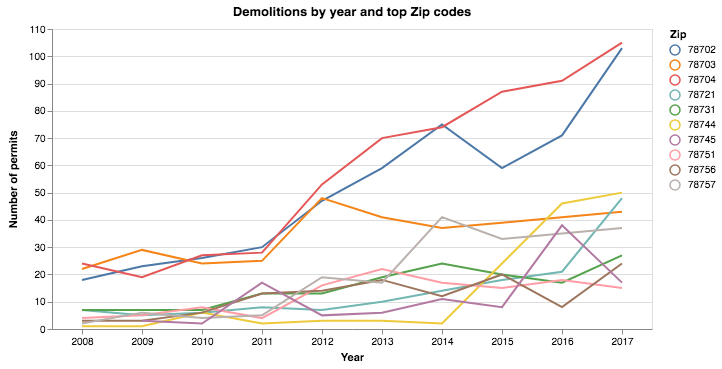

In [18]:
alt.Chart(top_demos_yr_zip, title="Demolitions by year and top Zip codes").mark_line().encode(
    x=alt.X("Year:O",
            axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    color="Zip"
).properties(width=600)

#### Alternate way to pick zips
In this case, I'm picking zips that had more than 10 demos in 2017.

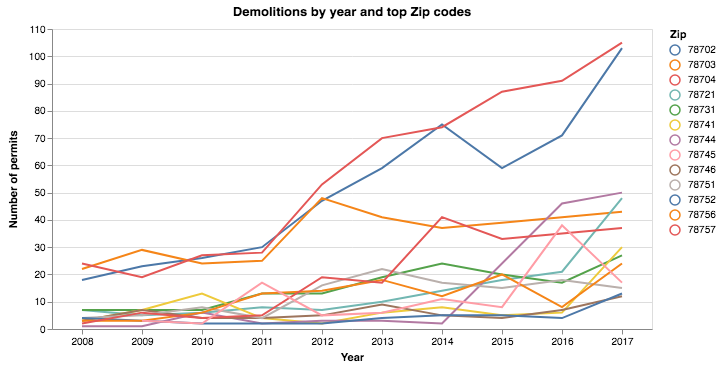

In [19]:
# filter to 2017
zips_2017 = demos_yr_zip[demos_yr_zip['Year'] == '2017']

# filter the 2017 list to those with 10+ demos
# sort the list by count descending
zips_2017_top = zips_2017[zips_2017.Count > 9].sort_values('Count', ascending=False)

# Use the Zip code column above to filter the original demos_yr_zip datatable
# and create the new dataframe to chart
top_demos_yr_zip_new = demos_yr_zip[demos_yr_zip['Zip'].isin(zips_2017_top.Zip)]

alt.Chart(top_demos_yr_zip_new, title="Demolitions by year and top Zip codes").mark_line().encode(
    x=alt.X("Year:O",
            axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    color="Zip"
).properties(width=600)

## A look at specific zip codes

### What's up with 78744, and is 2015 missing?

Noticing the increase in demolitions from 78744 in the graphic above, let's look a little deeper into them. It looks like the 2016 and 2017 increases are flood buyouts.

In [20]:
# show how many in each year
zip_78744 = demos_yr_zip_all[demos_yr_zip_all['Zip'] == '78744']
zip_78744

,Year,Zip,Count
11,2008,78744,1
33,2009,78744,1
59,2010,78744,6
84,2011,78744,2
113,2012,78744,3
137,2013,78744,3
163,2014,78744,2
218,2016,78744,46
248,2017,78744,50
274,2018,78744,4


In [21]:
# look at the descriptions of these homes
permits_78744 = demolitions[demolitions['OriginalZip'] == '78744']
permits_78744[['CalendarYearIssued', 'Description']].head(30)

,CalendarYearIssued,Description
93,2018,total demo of sf res flood mitigation
94,2018,total demo of sf res flood mitigation
151,2018,total demo of sf res 1978 flood mitigation
182,2018,Total demolition of existing sf res
317,2017,Total demolition of existing SFR City of Austin Flood Bu...
372,2017,Total demolition of existing duplex residence Built circ...
465,2017,total demo of sf res
528,2017,Total demolition of existing SFR City of Austin Flood Bu...
529,2017,Total demolition of existing SFR City of Austin Flood Bu...
545,2017,Total demolition of existing SFR City of Austin Flood Bu...


### Is 78741 the new demo target?

There was a big increase in 2017, so what's up with that? 2018 is not keeping pace. There were eight on the same piece of property, which is part of the increase, but others are more spread out. I have a Tableau map available to look at.

In [22]:
# show how many in each year
zip_78741 = demos_yr_zip_all[demos_yr_zip_all['Zip'] == '78741']
zip_78741

,Year,Zip,Count
10,2008,78741,3
31,2009,78741,7
57,2010,78741,13
83,2011,78741,4
111,2012,78741,2
136,2013,78741,6
161,2014,78741,8
188,2015,78741,5
216,2016,78741,6
246,2017,78741,30


In [23]:
# look at the descriptions of these homes
permits_78741 = demolitions[demolitions['OriginalZip'] == '78741']

# export all 78741 permist to csv to use later for a map
permits_78741.to_csv('../data-processed/permits_78741.csv')

# filter to 2017 to look at descriptions
permits_78741_2017 = permits_78741[permits_78741['CalendarYearIssued'] == '2017']
permits_78741_2017[['ProjectName', 'Description', 'ContractorCompanyName']].head(30)

,ProjectName,Description,ContractorCompanyName
284,919 VALDEZ ST,total demo home circa 1942,Precise Custom Homes Inc***MAIN***
288,904 VASQUEZ ST,total demo of house,Austin Triangle LLC
325,2006 MAXWELL LN,total demo of sf res 1950,NaN
331,6709 PONCA ST,total demo of home circa 1997,DAR Construction
338,500 BASTROP HWY SB,total demo of sf res circa 1957 2417 sq ft,DAR Construction
339,500 BASTROP HWY SB,total demo of sf res circa 1958 780 sq ft,DAR Construction
349,508 THRASHER LN,total demo of house circa 1945,DAR Construction
350,7409 E RIVERSIDE DR,total demo of sf res circa 1955,DAR Construction
351,7405 E RIVERSIDE DR,total demo of home circa 1954,DAR Construction
352,436 BASTROP HWY SB,total demo of sf res 1542 sf,DAR Construction


### A look at 78721
This is the area south of MLK between Airport and Ed Bluestein. Demolitions more than doubled in 2017 and is on pace to hold steady there in 2018.

The area on and around PENNSYLVANIA AVE, GRANT ST, FRANKLIN AVE has a pretty heavy concentration of demolitions in 2017, but there are a ton of others around, to.. In 2016, there was a strip on COMETA ST that was razed and replaced with a series of new duplexes.

I suspect but can't prove this is just the new hot spot for rebuilding/gentrification.

In [24]:
# show how many in each year
zip_78744 = demos_yr_zip_all[demos_yr_zip_all['Zip'] == '78721']
zip_78744

,Year,Zip,Count
4,2008,78721,7
24,2009,78721,5
51,2010,78721,6
76,2011,78721,8
101,2012,78721,7
128,2013,78721,10
154,2014,78721,14
181,2015,78721,18
206,2016,78721,21
237,2017,78721,48


In [39]:
permits_78721_2017 = demolitions[(demolitions.OriginalZip == "78721") & (demolitions.CalendarYearIssued == "2017")]
permits_78721_2017.OriginalAddress1

298       1142 BROOKSWOOD AVE
305              5005 ALF AVE
318            5005 HEFLIN LN
337       1153 WEBBERVILLE RD
342       1110 RICHARDINE AVE
345           1108 GARDNER CV
391           1104 SAUCEDO ST
406            1404 MARCUS PL
409        1101 SPRINGDALE RD
418           4908 LEDESMA RD
428     3501 PENNSYLVANIA AVE
431        4802 SANTA ANNA ST
432             1709 PEREZ ST
434            4704 LOUIS AVE
443     3413 PENNSYLVANIA AVE
444     3409 PENNSYLVANIA AVE
445     3602 PENNSYLVANIA AVE
446     3616 PENNSYLVANIA AVE
447             3601 GRANT ST
448             3607 GRANT ST
475           1102 SAUCEDO ST
503            1107 ESTES AVE
514          1706 OVERHILL DR
568              4601 ALF AVE
572            1300 COMETA ST
575           1142 ELEANOR ST
601            1125 EBERT AVE
617              4609 SARA DR
622        4706 SANTA ANNA ST
629            1130 MASON AVE
639            1119 WALTON LN
672             1412 PEREZ ST
677              1130 SPUR ST
700       

## Who is performing the demolitions?

The demolitions company is one who profits from this. Who does the most demolitions?

- This are just a rough look because I would need to clean the names to get an accurate count.

In [25]:
# top 10 by count 
demolitions.ContractorCompanyName.value_counts().head(10)

DAR Construction                        566
Southwest Destructors****MAIN***        227
Building Abatement Demolition Co Inc    104
AAR Inc.                                 84
MX3 Investments                          72
Absolute Demolition                      67
Heart of Texas Demolition, LLC           40
Pecan Valley Homes LLC***MAIN***         35
Paradisa Homes, LLC                      31
Gossett and Jones Homes Inc.             31
Name: ContractorCompanyName, dtype: int64

#### DAR Construction by year

In [26]:
# filter to just dar permits
dar_permits = demolitions[demolitions['ContractorCompanyName'] == 'DAR Construction']
dar_permits.shape

(566, 68)

In [27]:
dar_by_year = dar_permits.groupby(['CalendarYearIssued']).agg(dict(
    PermitNum='count'
)).reset_index()
dar_by_year.columns = ['Year', 'Count']
dar_by_year
# demos_yr_zip_all = demolitions.groupby(['CalendarYearIssued','OriginalZip']).agg(dict(
#     PermitNum='count'
# )).reset_index()
# demos_yr_zip_all.columns = ['Year', 'Zip', 'Count']
# demos_yr_zip_all.shape

,Year,Count
0,2008,5
1,2009,4
2,2010,9
3,2011,15
4,2012,39
5,2013,66
6,2014,86
7,2015,97
8,2016,92
9,2017,107


#### Check contractors different years

In [28]:
# group by year, contractor to count them.
contractor_group = demolitions.groupby(['CalendarYearIssued', 'ContractorCompanyName']).agg(dict(
    PermitNum='count'
)).reset_index()
# rename the columns
contractor_group.columns = ['Year', 'Contractor', 'Count']
# sort the columns so we can look at each year
contractor_sorted = contractor_group.sort_values(by=['Year', 'Count'], ascending=[1, 0])

In [29]:
# Look at top contractors each year
# change the year value to see other years
# DAR has lead by far since 2011
contractor_sorted[contractor_sorted.Year == '2018'].head(10)

,Year,Contractor,Count
1113,2018,DAR Construction,46
1086,2018,AAR Inc.,22
1179,2018,Southwest Destructors****MAIN***,16
1158,2018,"Paradisa Homes, LLC",14
1090,2018,Absolute Demolition,7
1135,2018,Journeyman Construction,5
1146,2018,MX3 Investments,5
1094,2018,Austin Demolition DJ- Homes,4
1133,2018,Joseph Builders LLC,4
1160,2018,Pecan Valley Homes LLC***MAIN***,4


## References
Ignore this. It's for column references.

In [30]:
demolitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 68 columns):
Unnamed: 0                    3165 non-null int64
PermitType                    3165 non-null object
PermitTypeDesc                3165 non-null object
PermitNum                     3165 non-null object
PermitClassMapped             3165 non-null object
PermitClass                   3165 non-null object
WorkClass                     3165 non-null object
Condominium                   3165 non-null object
ProjectName                   3165 non-null object
Description                   3165 non-null object
TCAD_ID                       3151 non-null object
PropertyLegalDescription      2745 non-null object
AppliedDate                   3165 non-null object
IssuedDate                    3165 non-null datetime64[ns]
DayIssued                     3165 non-null object
CalendarYearIssued            3165 non-null object
FiscalYearIssued              3165 non-null int64
IssuedInLast30Days  